<h1><center>Quantitative Input Influence</center></h1>
<h2><center> A study on influence of inputs on automated recidivism decisions</center></h2>
<center>Karina Huang, Lipika Ramaswamy  </center>
<center>AC221: Critical Thinking in Data Science </center>
<center>Spring 2019</center>

In [39]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## I. Introduction

Responsible data science is necessary because of its impact on decision making. Consider the fairness of automated decision making in hiring and sentencing procedures. While fairness of algorithms remains debatable depending on how the term is defined, lack of interpretability in algorithms complicates the debate; if it remains unclear what comprises a decision, it will be difficult to compartmentalize what makes the decision fair or unfair. Therefore, it is necessary that an algorithm be presented as clearly as possible. Granting algorithmic transparency helps facilitate discussions on the fairness of model design and consequences.

One approach to quantifying the interpretability of a model is the Quantitative Input Influence (QII) framework introduced by Datta et al. in their paper, *Algorithmic Transparency via Quantitative Input Influence*. These are causal measures that explain the influence of an input or a set of inputs on the decision made by machine learning algorithms. Transparency queries that use QII measures can be used to explain decisions about the classification outcome for an individual or a group. Specifically, for a quantity of infuence, *Q*, and an input feature, *i*, the QII of *i* on *Q* is the difference in *Q* when *i* is changed via intervention. In other words, we can replace features with random values from the population, and examine the distribution over outcomes for changes.

In the current study, we examined this framework using the [COMPAS dataset](https://github.com/propublica/compas-analysis). ProPublica has previous published a [study](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) claiming the scoring system as biased against African American individuals. Our objectives were to evaluate the validity of such claim by:

* examining the average importance of individual attributes on individual outcomes in modeling the COMPAS decile score categories (low, medium, high)
* comparing the QII outcomes on group disparity, with respect to the probability of being predicted in a decile score category
* investigating marginal influence of attributes on individuals in the dataset through transparency reports

## II. Data

ProPublica included 3 datasets on their Github page. Due to a lack of documentation regarding how the data was cleaned (we found discrepancies in the their reported methods and the actual dataset), we examined each of the dataset and chose to use the dataset in `compas-scores-two-years.csv`. Below we report the preliminary characteristics of the dataset.

In [2]:
#load data
data = pd.read_csv('../data/data_final.csv', index_col = ['Unnamed: 0'])
#check dataset
print('The size of this dataset is', data.shape)
data.head()

The size of this dataset is (7214, 15)


,id,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,decile_score,score_text,is_recid,v_decile_score,v_score_text,is_violent_recid,two_year_recid
0,1,Male,69,Other,0,0,0,0,1,Low,0,1,Low,0,0
1,3,Male,34,African-American,0,0,0,0,3,Low,1,1,Low,1,1
2,4,Male,24,African-American,0,0,1,4,4,Low,1,3,Low,0,1
3,5,Male,23,African-American,0,1,0,1,8,High,0,6,Medium,0,0
4,6,Male,43,Other,0,0,0,2,1,Low,0,1,Low,0,0


In [3]:
#demographics
print('Number of unique individuals in dataset: ', len(data.id.unique()))
print('Proportion female: ', np.round(data.sex.value_counts()[1]/(data.sex.value_counts()[1]+
                                                                  data.sex.value_counts()[0]),2))
print('Mean age: ', np.round(np.mean(data.age.values), 2))

Number of unique individuals in dataset:  7214
Proportion female:  0.19
Mean age:  34.82


In [4]:
#check counts by violence decile score categories 
data.v_score_text.value_counts()

Low       4761
Medium    1739
High       714
Name: v_score_text, dtype: int64

In [5]:
#check counts by race
data.race.value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

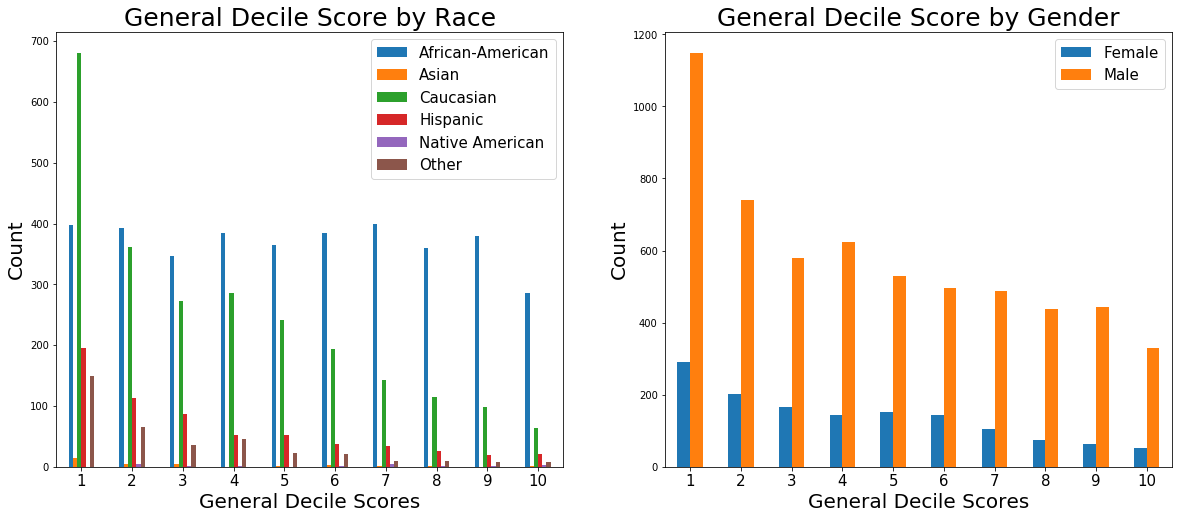

In [6]:
#visualization
#general decile score by race and sex
genDR = data.groupby(['decile_score', 'race']).agg({'id': len}).unstack()

genDS = data.groupby(['decile_score', 'sex']).agg({'id': len}).unstack()

#visualize demographics
dfs = [genDR, genDS]
labels = ['Race', 'Gender']
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
for i, ax in enumerate(axes.flat):
    dfs[i].plot(ax = ax, kind = 'bar')
    ax.set_xticklabels(labels = dfs[i].index, rotation = 360, fontsize = 15)
    ax.set_xlabel('General Decile Scores', fontsize = 20)
    ax.set_ylabel('Count', fontsize = 20)
    ax.legend(list(dfs[i].columns.levels[1]), fontsize = 15)
    ax.set_title('General Decile Score by '+labels[i], fontsize = 25)
plt.show()

## III. Methodology

### Models

Using ProPublica's data, we model the violence decile categorization (low, medium, high) of an individual using various other attributes, including age, juvenile misdemeanor count, priors count, sex and race. The goal here is to reconstruct COMPAS assignments to violence decile categorization given that it is a blackbox algorithm. Effectively, we are trying to reconstruct a blackbox algorithm to use the framework described below.

Given the classification task at hand, we chose to employ Logistic Regression, a Support Vector Machine and a Decision Tree for the problem. 

### Quantitative Input Influence 

Given a black-box algorithm, $A$, we first define a quantity of interest, $Q$, which represents a property of the behavior of the algorithm for a given input distribution. $A$ operates on inputs or features, $i$, and every $i$ has a set of possible states it can take on, and $\mathbf{x}\in X$ is any vector representing a row the dataset that is drawn from the true *underlying* distribution represented by the random variable $X$. In the particular problem explored here, an example of an algorithm is Logistic Regression and an example of a feature is `race`, which can take on the following states: African-American, Caucasian, Hispanic, Asian, Native American and Other.

Formally, for a quantity of interest $Q_A(\cdot)$ and an input $i$, the Quantitative Input Influence of $i$ on $Q_A(\cdot)$ is defined as:
$$ \iota^{Q_A} = Q_A (X) - Q_A(X_{-i} U_i),$$
where the random variable $X_{-i}U_i$ represents the random variable with input $i$ replaced with a random sample, and represents the *intervened* distribution.

#### Unary QII
1. QII for individual outcomes:
    
    **One use of QII is to provide individuals with information on a particular classification outcome**. In order to quantify the use of an input for individual outcomes, we define the quantity of interest to be the classification outcome, $c$, for a particular individual, $\mathbf{x}$, given by $Q_{ind}^{\mathbf{x}} (\cdot) = \mathbb{E}(c(\cdot) = 1 | X = \mathbf{x})$. We can define the QII as: 
    $$ \iota^{\mathbf{x}}_{ind} =\mathbb{E}(c(X) = 1 | X = \mathbf{x}) - \mathbb{E}(c(X_{-i}U_i) = 1 | X = \mathbf{x})$$
    
   In our specific application, we are interested in the probability that a given feature is pivotal to the classification of an individual. We define this mathematically as:
   $$ \sum_{\mathbf{x}\in X}Pr(X=\mathbf{x}) \cdot \mathbb{E}(i\text{ is pivotal for }c(X)|X=\mathbf{x}) = \mathbb{E}(i\text{ is pivotal for }c(X))$$
    
2. QII for group disparity:

    **QII on group disparity denotes the association between classification outcomes and membership in a group.** In this case, the quantity of interest is the difference of postive classification outcomes between a given group and all others.
    $$Q_{disp}^\mathcal{Y} (\cdot)  = | \mathbb{E}(c(\cdot) = 1 | X \in \mathcal{Y}) -  \mathbb{E}(c(\cdot) = 1 | X \notin \mathcal{Y})|$$
    
    We can thus define the QII as: 
    $$\iota_{disp}^{\mathcal{Y}}(i) = Q_{disp}^{\mathcal{Y}} (X) - Q_{disp}^{\mathcal{Y}} (X_{-i}U_i)$$
    
 
#### Set and Marginal QII

In the overwhelming majority of real datasets, it is impossible to look at the *individual* influence of one feature on an outcome, as it is likely correlated with other features that were included in the decision making process. Thus, if we intervene on only one feature, changes to the outcome will be less likely, as the features correlated with it will still capture some of the feature in question's impact. So if we intervene on sets of features including a given feature, we may get a better understanding of the influence of this feature by looking at its marginal influence.

For a quantity of interest, $Q$, and an input $i$, the QII of input $i$ over a set $S\subseteq N$ on $Q$ is defined to be

$$\iota^Q(i,S) = Q(X_{-S}U_{S}) - Q(X_{-S\cup\{i\}}U_{S\cup\{i\}})$$ 

It is clear from the equation that the marginal QII of $i$ is the additional value in transparency achieved by including $i$ in a subset of features.

The marginal contribution of $i$ can vary depending on which set $S$ is considered, so we report the aggregate marginal contribution of $i$ to $S$, where S is sampled from some distribution over subsets of features. We use the Shapley value as a measure of this aggregate marginal contribution. This is what we present in transparency reports for an individual.


## IV. Evaluation and Results

In [7]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('../qii_analysis/')
from qii_analysis import QII
os.chdir('../models/')
pd.set_option('display.max_columns', 500)

#import qii package
from qii_analysis import QII

In [8]:
#get dummy variables
data_new = pd.get_dummies(data, columns = ['sex', 'race'])

#set predictor and response columns
predictors = ['age', 'juv_misd_count', 'priors_count', 'sex_Female', 
              'sex_Male', 'race_African-American', 'race_Asian', 
              'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']

# vR = ['v_decile_score']
vR = ['v_score_text']

#train test split data 
train, test = train_test_split(data_new, test_size = 0.20, random_state = 221)

#get QII objects
dt = QII(train, test, predictors, vR)
lg = QII(train, test, predictors, vR)
svm = QII(train, test, predictors, vR)

#get models
dt.getModel('Decision Tree')
lg.getModel('Logistic Regression')
svm.getModel('SVM')

#### Classification Accuracy

Overall the Support Vector Machine generated the best out-of-sample prediction accuracy and F1-score; a high f1 score indicates low false positives and false negatives. 

In [11]:
#classification accuracy
print('Decision Tree: ')
dt.getAccuracy(training = False)
dt.getF1(training = False)
print('-'*110)
print('Logistic Regression: ')
lg.getAccuracy(training = False)
lg.getF1(training = False)
print('-'*110)
print('Support Vector Machine: ')
svm.getAccuracy(training = False)
svm.getF1(training = False)
print('-'*110)

Decision Tree: 
Test Prediction Accuracy:  0.7172557172557172
Test F1 Score:  0.7282290644902742
--------------------------------------------------------------------------------------------------------------
Logistic Regression: 
Test Prediction Accuracy:  0.7331947331947332
Test F1 Score:  0.7905109954134039
--------------------------------------------------------------------------------------------------------------
Support Vector Machine: 
Test Prediction Accuracy:  0.762993762993763
Test F1 Score:  0.7969124345782171
--------------------------------------------------------------------------------------------------------------


#### Unary QII on Individual Outcomes

The classifiers rendered overall the same feature importance ranking. The plots below displays the difference in feature importance by classifiers and decile score catogories. The y axis indicate the probability of being classified into the respective decile score category between using the actual data and using some randomly permuted data for all individuals. The larger this QII value, the more the respective classifier and the decision relies on the given feature. For low and medium decile scores, _priors count_ was the most significant factor of classification, followed by _age_ and _juvenile misdemeanor count_. Interestingly, age was the most significant determinant in categorization of high violent decile scores. Note that the feature importances vary depending on the classifier, however, the magnitude is arguably minor.  

In [12]:
#unary qii influence of individual outcomes by feature and decile score category
dtLow, dtMed, dtHigh = dt.getUnaryInd()
lgLow, lgMed, lgHigh = lg.getUnaryInd()
svmLow, svmMed, svmHigh = svm.getUnaryInd()

In [14]:
#save history for because it takes a long time to run the code
dt_unaryInd = np.save('../models/dt_unaryInd.npy', (dtLow, dtMed, dtHigh))
lg_unaryInd = np.save('../models/lg_unaryInd.npy', (lgLow, lgMed, lgHigh))
svm_unaryInd = np.save('../models/svm_unaryInd.npy', (svmLow, svmMed, svmHigh))

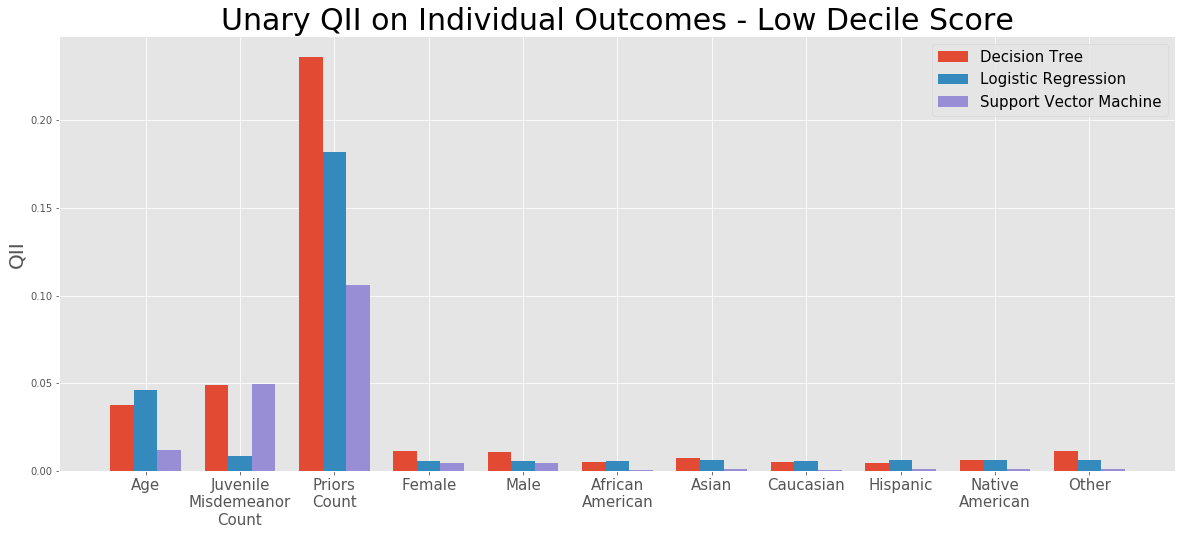

In [49]:
ind = np.arange(len(predictors)) 
width = 0.25  
labels = ['Age', 'Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'Female', 'Male', 'African\nAmerican',
          'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dtLow, width, label='Decision Tree')
rects2 = ax.bar(ind , lgLow, width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svmLow, width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Unary QII on Individual Outcomes - Low Decile Score', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

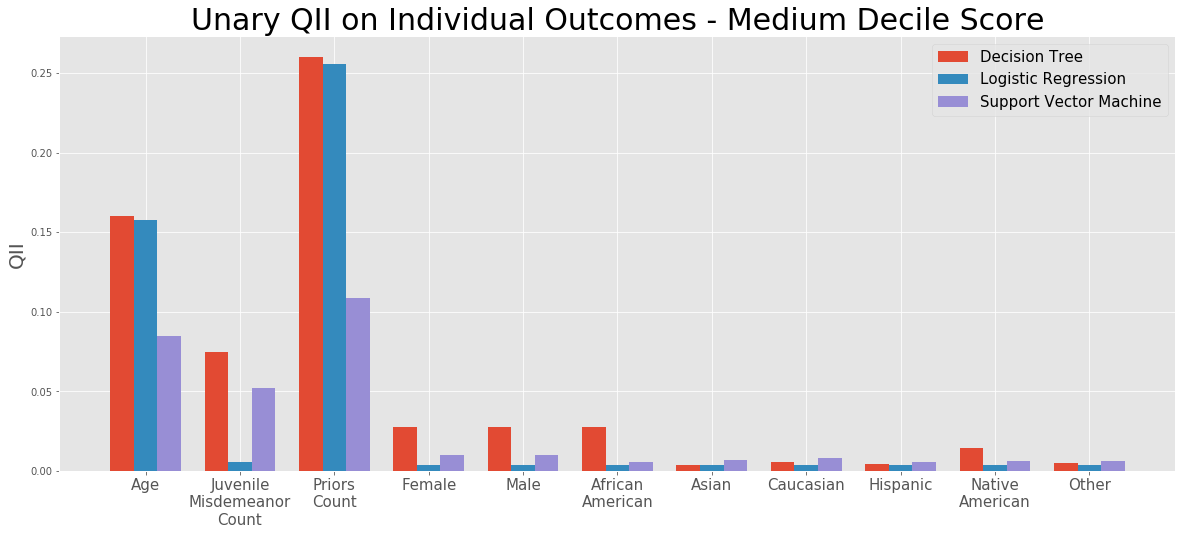

In [50]:
ind = np.arange(len(predictors)) 
width = 0.25  
labels = ['Age', 'Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'Female', 'Male', 'African\nAmerican',
          'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dtMed, width, label='Decision Tree')
rects2 = ax.bar(ind , lgMed, width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svmMed, width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Unary QII on Individual Outcomes - Medium Decile Score', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

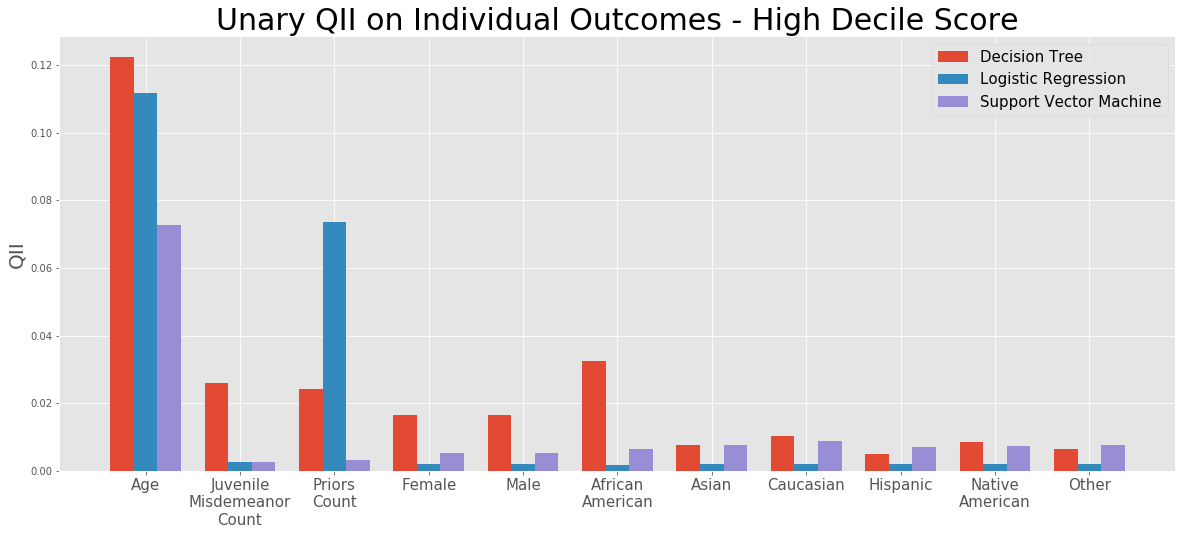

In [51]:
ind = np.arange(len(predictors)) 
width = 0.25  
labels = ['Age', 'Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'Female', 'Male', 'African\nAmerican',
          'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dtHigh, width, label='Decision Tree')
rects2 = ax.bar(ind , lgHigh, width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svmHigh, width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Unary QII on Individual Outcomes - High Decile Score', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

#### Unary QII on Group Disparity

There are two grouping factors in the current dataset: 1) sex, and 2) race. Our function allows for comparison between any given reference group to the rest, for demonstration purposes, we report below results of 1) group disparity between male and female, and 2) group disparty between Caucasian and other. As for unary QII on individual outcomes, the y-axis indicate the discrepancy between being classified a certain decile score group given the actual vs. random attributes. For group disparity, we held all other variables constant and randomly sampled the group assignment for each individual in the dataset. Therefore, a positive QII indicate a more consistent disparity in probability of being assigned a certain decile score group due to the randomized demographics information. 

**Male vs. Female**

For the low decile score group, the plots indicate that there is some discrepancy in being assigned this decile score category between male and female groups. This discrepancy can be attributed to age by all three classifiers. Interestingly, priors count did not seem to matter for the decision tree classifier. For the medium decile score group, the plots indicate that age, priors count, and juvenile misdemeanor counts contributed to the discrepancy of assignment due to gender. Interestigly, for the high decile score group, juvenile misdemeanor count and priors count did not seem to be discriminating inputs for discrepancy between assignments for male and female. While the discrepancy is arguably minor, race appeared to have some effect towards gender group disparity. Most notably, for all decile score categories, the decision tree classifier always considered race to be important. 

**Caucasian vs. Other**

For all decile score categories and classifiers, age appeared to be an important discrinant for discrepancy between assignments for Caucasian and non-Caucasian individuals. Priors count seemed to matter for low and medium decile score categories, but interestingly, not for high decile score category.

In [53]:
#unary qii influence on group disparity by feature and decile score category
dtLow_sex, dtMed_sex, dtHigh_sex, dtLabels_sex = dt.getUnaryGrp('sex', 'sex_Male')
lgLow_sex, lgMed_sex, lgHigh_sex, lgLabels_sex  = lg.getUnaryGrp('sex', 'sex_Male')
svmLow_sex, svmMed_sex, svmHigh_sex, svmLabels_sex = svm.getUnaryGrp('sex', 'sex_Male')

In [54]:
#save history for because it takes a long time to run the code
dt_unaryGrp_sex = np.save('../models/dt_unaryGrp_sex.npy', (dtLow_sex, dtMed_sex, dtHigh_sex, dtLabels_sex))
lg_unaryGrp_sex = np.save('../models/lg_unaryGrp_sex.npy', (lgLow_sex, lgMed_sex, lgHigh_sex, lgLabels_sex))
svm_unaryGrp_sex = np.save('../models/svm_unaryGrp_sex.npy', (svmLow_sex, svmMed_sex, svmHigh_sex, svmLabels_sex ))

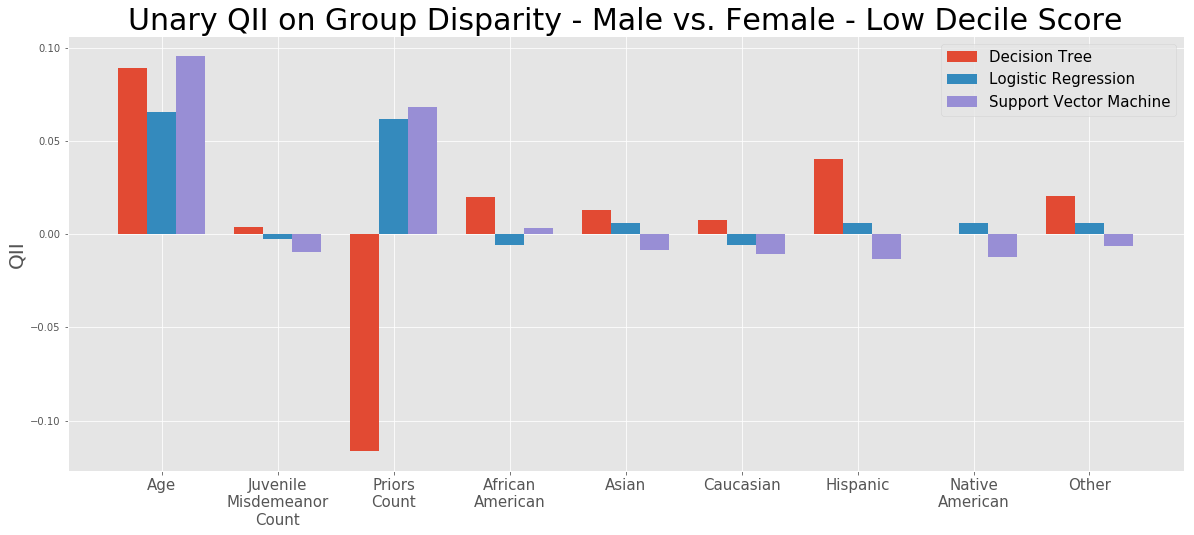

In [59]:
ind = np.arange(len(dtLabels_sex)) 
width = 0.25  
labels = ['Age', 'Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'African\nAmerican',
          'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dtLow_sex, width, label='Decision Tree')
rects2 = ax.bar(ind , lgLow_sex, width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svmLow_sex, width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Unary QII on Group Disparity - Male vs. Female - Low Decile Score', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

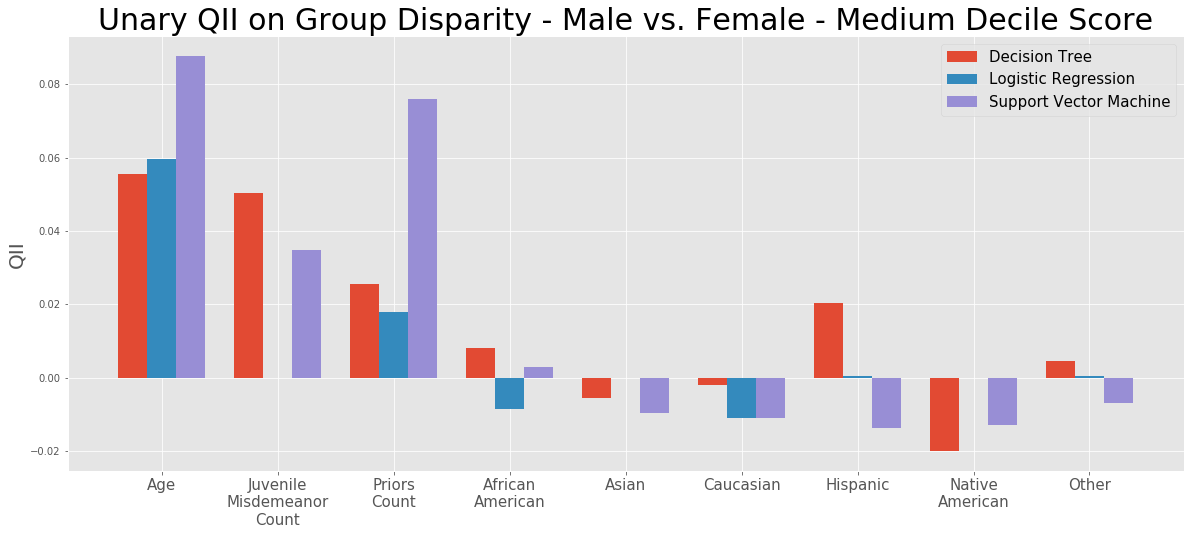

In [60]:
ind = np.arange(len(dtLabels_sex)) 
width = 0.25  
labels = ['Age', 'Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'African\nAmerican',
          'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dtMed_sex, width, label='Decision Tree')
rects2 = ax.bar(ind , lgMed_sex, width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svmMed_sex, width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Unary QII on Group Disparity - Male vs. Female - Medium Decile Score', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

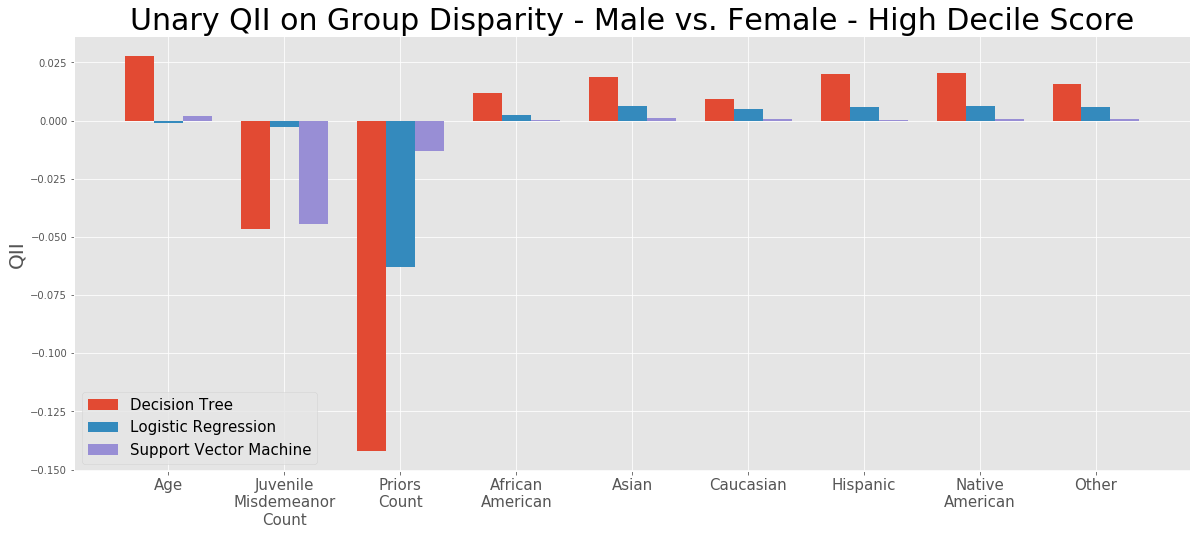

In [61]:
ind = np.arange(len(dtLabels_sex)) 
width = 0.25  
labels = ['Age', 'Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'African\nAmerican',
          'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dtHigh_sex, width, label='Decision Tree')
rects2 = ax.bar(ind , lgHigh_sex, width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svmHigh_sex, width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Unary QII on Group Disparity - Male vs. Female - High Decile Score', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

In [62]:
#unary qii influence on group disparity by feature and decile score category
dtLow_race, dtMed_race, dtHigh_race, dtLabels_race = dt.getUnaryGrp('race', 'race_Caucasian')
lgLow_race, lgMed_race, lgHigh_race, lgLabels_race  = lg.getUnaryGrp('race', 'race_Caucasian')
svmLow_race, svmMed_race, svmHigh_race, svmLabels_race = svm.getUnaryGrp('race', 'race_Caucasian')

In [63]:
#save history for because it takes a long time to run the code
dt_unaryGrp_race = np.save('../models/dt_unaryGrp_race.npy', (dtLow_race, dtMed_race, dtHigh_race, dtLabels_race))
lg_unaryGrp_race = np.save('../models/lg_unaryGrp_race.npy', (lgLow_race, lgMed_race, lgHigh_race, lgLabels_race))
svm_unaryGrp_race = np.save('../models/svm_unaryGrp_race.npy', (svmLow_race, svmMed_race, svmHigh_race, svmLabels_race ))

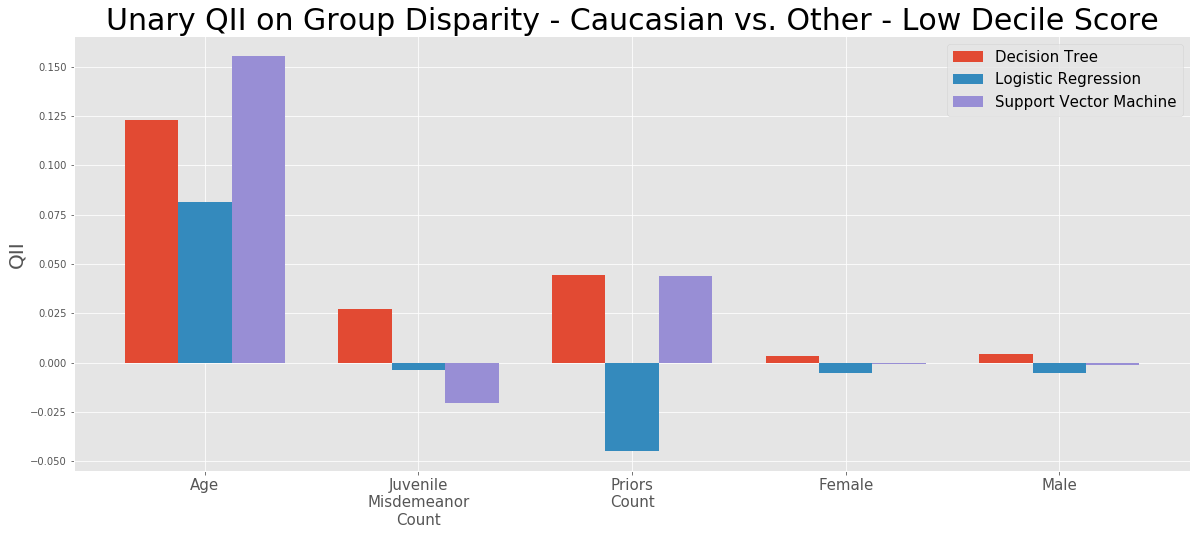

In [64]:
ind = np.arange(len(dtLabels_race)) 
width = 0.25  
labels = ['Age', 'Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'Female', 'Male']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dtLow_race, width, label='Decision Tree')
rects2 = ax.bar(ind , lgLow_race, width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svmLow_race, width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Unary QII on Group Disparity - Caucasian vs. Other - Low Decile Score', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

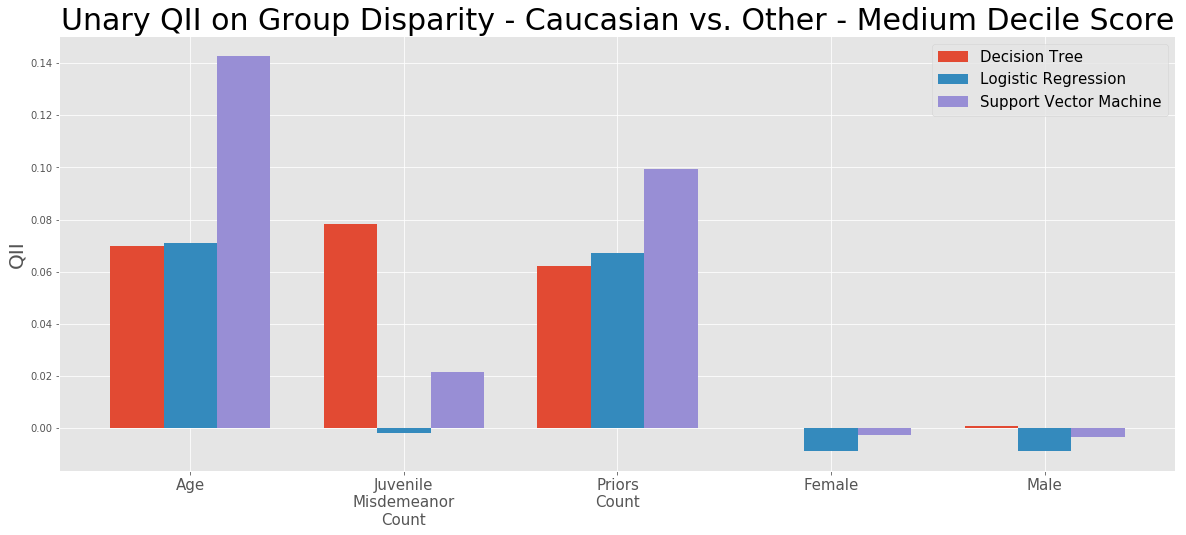

In [65]:
ind = np.arange(len(dtLabels_race)) 
width = 0.25  
labels = ['Age', 'Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'Female', 'Male']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dtMed_race, width, label='Decision Tree')
rects2 = ax.bar(ind , lgMed_race, width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svmMed_race, width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Unary QII on Group Disparity - Caucasian vs. Other - Medium Decile Score', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

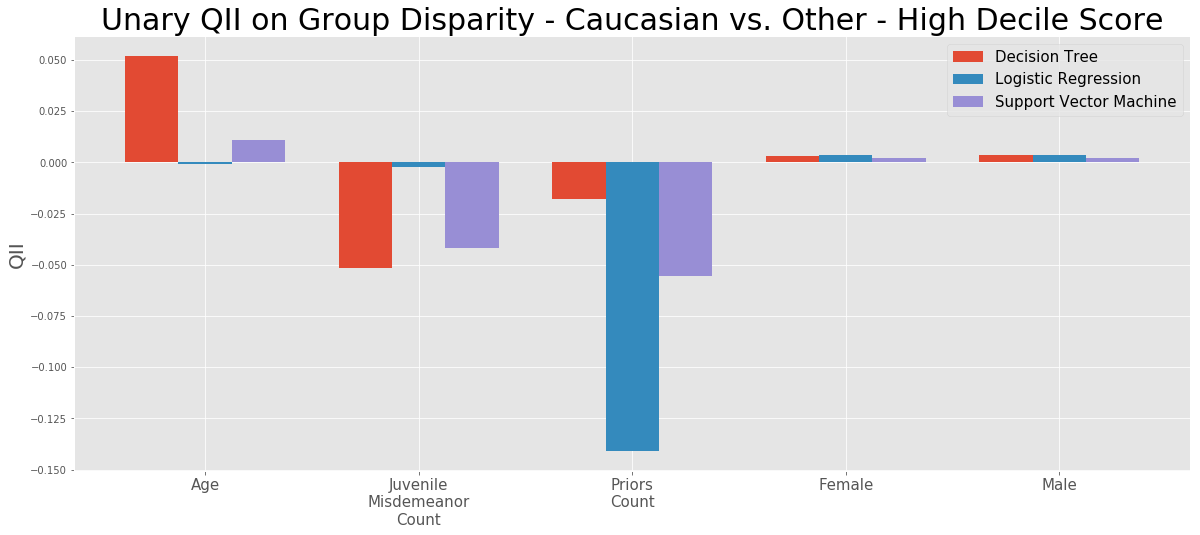

In [66]:
ind = np.arange(len(dtLabels_race)) 
width = 0.25  
labels = ['Age', 'Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'Female', 'Male']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dtHigh_race, width, label='Decision Tree')
rects2 = ax.bar(ind , lgHigh_race, width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svmHigh_race, width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Unary QII on Group Disparity - Caucasian vs. Other - High Decile Score', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

#### Transparency Report - Marginal QII

Transparency report can provide individuals, such as Ms.X, on detailed information on their classification outcomes. In the plot below, we observe that the decision tree classifier appeared to have weighted each feature more heavily than the other classifiers. Essentially, this method can be applied to all individuals in the dataset in investigating featuer importance. Note that the classifiers do not necesarily yield the same classification outcomes for a given individual. 

In [100]:
#transparency report demo
varList = ['juv_misd_count', 'priors_count', 'race_African-American', 'age' , 'sex_Female']
dt_idx158 = dt.getSetQII(158, varList)
lg_idx158 = lg.getSetQII(158, varList)
svm_idx158 = svm.getSetQII(158, varList)

In [105]:
print('Information on Ms.X: ')
pd.DataFrame(test.loc[158, ]).rename(columns = {158: 'Ms.X'})

Information on Ms.X: 


,Ms.X
id,241
age,26
juv_fel_count,0
juv_misd_count,0
juv_other_count,0
priors_count,2
decile_score,4
score_text,Low
is_recid,1
v_decile_score,4


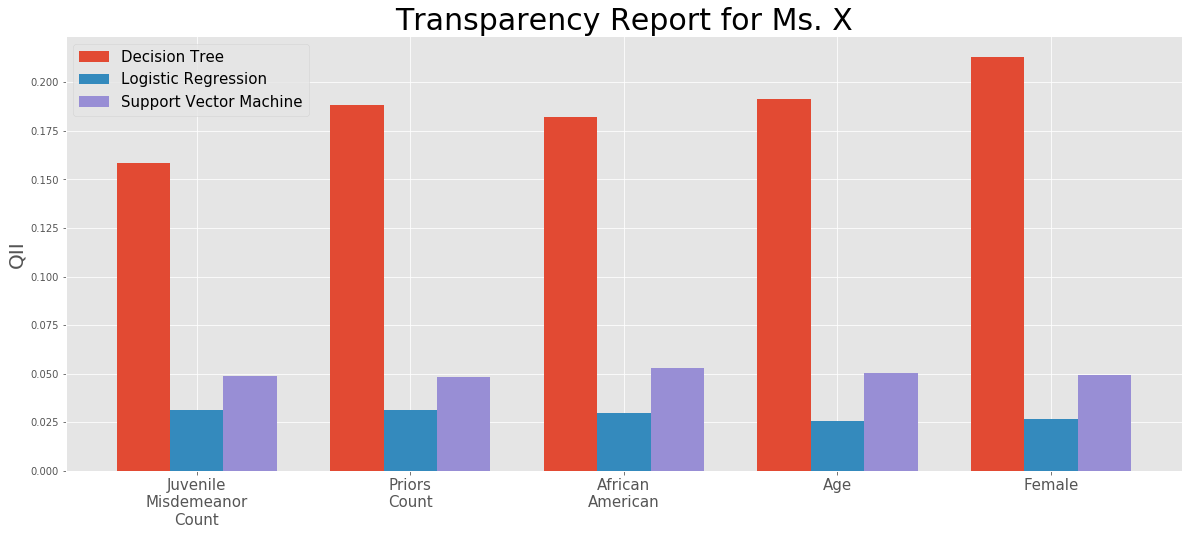

In [102]:
ind = np.arange(len(dtLabels_race)) 
width = 0.25  
labels = ['Juvenile\nMisdemeanor\nCount', 
          'Priors\nCount', 'African\nAmerican', 'Age', 'Female']
fig, ax = plt.subplots(figsize = (20, 8))

rects1 = ax.bar(ind - width, dt_idx158.values(), width, label='Decision Tree')
rects2 = ax.bar(ind , lg_idx158.values(), width,label='Logistic Regression')
rects3 = ax.bar(ind +1*width, svm_idx158.values(), width,label='Support Vector Machine')

ax.set_ylabel('QII', fontsize = 20)
ax.set_title('Transparency Report for Ms. X', fontsize = 30)
ax.set_xticks(ind)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

## V. Future Work

#### Improve classifier performance
This problem has been tackled using classifiers that have been minimally tuned. We recognize that the best classification accuracy achieved by any of our models on out-of-sample predictions is 76.3% (SVM), which clearly falls short of perfectly predicting COMPAS scores. Had our goal been to predict COMPAS scores accurately, we would have balanced classes using some synthetic oversampling technique. Further, hyperparameter tuning could also be done to try for better model performance.

#### Differentially private releases
Given their construction, transparency reports can reveal sensitive information about the all data used to train the decision aiding classifier. We recommend making either the classifiers themselves differentially private (see [Abadi et al.](https://arxiv.org/pdf/1607.00133.pdf) or making the release of transparency reports differentially private by addition of noise. Note that these procedures are computationally expensive for large data, so we leave it as an extension to our QII work.

___